In [1]:
# imports
import os
from typing import Tuple
import scipy.stats as stats
import torch as t
from torch.nn.functional import conv2d, pad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import imageio
from scipy import ndimage
from tqdm import tqdm
import pandas as pd

In [2]:
# set device
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

In [3]:
# get_active_pixel_idx(batch: t.Tensor) -> Returns list of indices where pixels > 0
def get_active_pixel_idx(batch:t.Tensor) -> t.Tensor:
    return batch.nonzero().T

In [4]:
def take_step(batch:t.Tensor, v_cur, p_vchg, facing_left, p_reverse, dim=-1) -> t.Tensor: 
    # find active pixels
    act_pixel_idx = get_active_pixel_idx(batch)
    batch_size,height,width = batch.shape

    # determine pixels next to active pixel (uses periodic torus)
    left_px = act_pixel_idx.clone()
    right_px = act_pixel_idx.clone()
    left_px[dim] -= 1
    right_px[dim] += 1
    left_px[dim][left_px[dim] < 0] = width -1
    right_px[dim][right_px[dim] == width] = 0

    # update the direction of the cells
    logits = t.hstack([t.log(1-p_reverse).unsqueeze(-1), t.log(p_reverse).unsqueeze(-1)])
    logit_tile = logits.repeat((batch_size,1))
    outcome = t.nn.functional.gumbel_softmax(logit_tile, tau=1, hard=True)
    facing_left = facing_left * outcome[:,0] + (1 - facing_left) * outcome[:,1]
    
    # update the velocity of the cells
    logits_vchg = t.hstack([t.log(1-p_vchg), t.log(p_vchg)])
    logit_tile_vchg = logits_vchg.repeat((batch_size,1))
    v_chg = t.nn.functional.gumbel_softmax(logit_tile_vchg, tau=1, hard=True)
    v_cur = v_cur * v_chg[:,0] + (1-v_cur) * v_chg[:,1]

    batch[act_pixel_idx[0], act_pixel_idx[1], act_pixel_idx[2]] -= 1 * v_cur

    batch[left_px[0], left_px[1], left_px[2]] += facing_left * v_cur
    batch[right_px[0], right_px[1], right_px[2]] += (1-facing_left) * v_cur
    return batch, facing_left, v_cur

In [5]:
def init_batch(n:int, dim:int, init_v_rand=False, device=t.device("cpu")):
    batch = t.zeros((n,dim,dim), device=device)
    batch[:,dim//2,dim//2] = 1
    facing_left_x = t.bernoulli(t.tensor(0.5, device=device).repeat(n))
    facing_left_y = t.bernoulli(t.tensor(0.5, device=device).repeat(n))
    v_x = t.ones((n), device=device)
    v_y = t.ones((n), device=device)
    return batch, facing_left_x, facing_left_y, v_x, v_y

In [6]:
# create_dist_matrix(batch:t.Tensor) -> Create distance matrix with same width/height as reference batch
def create_dist_matrix(batch:t.Tensor, device=t.device("cpu")) -> t.Tensor:   
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [7]:
# calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Returns (sq_distances, avg_sq_distance, std_distance)
def calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
    distances = (dist_matrix[batch.nonzero(as_tuple=True)[1:]] * batch[batch.nonzero(as_tuple=True)])
    return distances, t.mean(distances), t.std(distances)

# Visualize model

tensor([1.], device='cuda:0') tensor([1.], device='cuda:0') tensor([1.], device='cuda:0') tensor([1.], device='cuda:0')


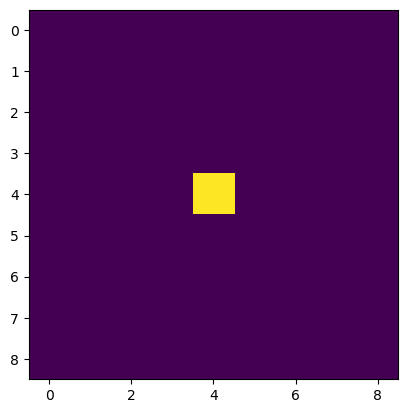

tensor([1.], device='cuda:0') tensor([1.], device='cuda:0')


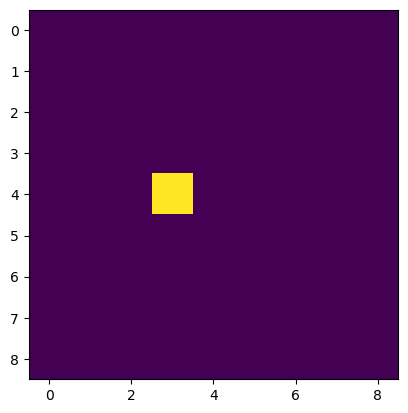

In [68]:
test_batch, dir_x, dir_y, v_x, v_y = init_batch(1,9,device=device)
print(dir_x,dir_y,v_x,v_y)
plt.imshow(test_batch[0].cpu())
plt.show()
test_batch, dir_x, v_x = take_step(test_batch, v_x, t.tensor(0.5,device=device), dir_x, t.tensor(0.5, device=device), dim=-1)
print(dir_x,v_x)
plt.imshow(test_batch[0].cpu())
plt.show()

# Experiment optim 

In [46]:
p_reverse = t.tensor(0.9,device=device)
p_reverse.requires_grad_()
p_vchg = t.tensor(0.9,device=device)
p_vchg.requires_grad_()
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)
target_msd = 100

p_rev_vals = [p_reverse.detach().clone().cpu().numpy()]
p_vchg_vals = [p_vchg.detach().clone().cpu().numpy()]
grads_rev = []
grads_vchg = []
msds = []
losses = []

t.autograd.set_detect_anomaly(False)

In [49]:
for i in tqdm(range(50)):
    test_batch, dir_x, dir_y, v_x, v_y = init_batch(200,512,device=device)
    #print(dir_x.shape)
    for j in range(100):
        test_batch, dir_x, v_x = take_step(test_batch, v_x, p_vchg, dir_x, p_reverse, dim=-1)
        test_batch, dir_y, v_y = take_step(test_batch, v_y, p_vchg, dir_y, p_reverse, dim=-2)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - target_msd)**2
    grad_rev, grad_vchg = t.autograd.grad(loss,(p_reverse, p_vchg))
    p_reverse = t.clamp(p_reverse - 1e-8 * grad_rev, min=0, max=1)
    p_vchg = t.clamp(p_vchg - 1e-8 * grad_vchg, min=0, max=1)

    print(p_reverse,p_vchg)
    p_rev_vals.append(p_reverse.detach().clone().cpu().numpy())
    p_vchg_vals.append(p_vchg.detach().clone().cpu().numpy())
    grads_rev.append(grad_rev.detach().clone().cpu().numpy())
    grads_vchg.append(grad_vchg.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())


  2%|▏         | 1/50 [00:03<02:36,  3.20s/it]

tensor(0.7958, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7555, device='cuda:0', grad_fn=<ClampBackward1>)


  4%|▍         | 2/50 [00:06<02:28,  3.10s/it]

tensor(0.7930, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7522, device='cuda:0', grad_fn=<ClampBackward1>)


  6%|▌         | 3/50 [00:09<02:24,  3.07s/it]

tensor(0.7923, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7513, device='cuda:0', grad_fn=<ClampBackward1>)


  8%|▊         | 4/50 [00:12<02:20,  3.05s/it]

tensor(0.7907, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<ClampBackward1>)


 10%|█         | 5/50 [00:15<02:16,  3.04s/it]

tensor(0.7900, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7487, device='cuda:0', grad_fn=<ClampBackward1>)


 12%|█▏        | 6/50 [00:18<02:13,  3.04s/it]

tensor(0.7901, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7488, device='cuda:0', grad_fn=<ClampBackward1>)


 14%|█▍        | 7/50 [00:21<02:10,  3.03s/it]

tensor(0.7902, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7489, device='cuda:0', grad_fn=<ClampBackward1>)


 16%|█▌        | 8/50 [00:24<02:07,  3.03s/it]

tensor(0.7893, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7477, device='cuda:0', grad_fn=<ClampBackward1>)


 18%|█▊        | 9/50 [00:27<02:04,  3.03s/it]

tensor(0.7904, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7488, device='cuda:0', grad_fn=<ClampBackward1>)


 20%|██        | 10/50 [00:30<02:01,  3.03s/it]

tensor(0.7902, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7485, device='cuda:0', grad_fn=<ClampBackward1>)


 22%|██▏       | 11/50 [00:33<01:58,  3.03s/it]

tensor(0.7903, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7487, device='cuda:0', grad_fn=<ClampBackward1>)


 24%|██▍       | 12/50 [00:36<01:55,  3.03s/it]

tensor(0.7903, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7487, device='cuda:0', grad_fn=<ClampBackward1>)


 26%|██▌       | 13/50 [00:39<01:52,  3.03s/it]

tensor(0.7908, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<ClampBackward1>)


 28%|██▊       | 14/50 [00:42<01:48,  3.03s/it]

tensor(0.7908, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7493, device='cuda:0', grad_fn=<ClampBackward1>)


 30%|███       | 15/50 [00:45<01:45,  3.03s/it]

tensor(0.7903, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7487, device='cuda:0', grad_fn=<ClampBackward1>)


 32%|███▏      | 16/50 [00:48<01:42,  3.03s/it]

tensor(0.7912, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7501, device='cuda:0', grad_fn=<ClampBackward1>)


 34%|███▍      | 17/50 [00:51<01:39,  3.03s/it]

tensor(0.7914, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7505, device='cuda:0', grad_fn=<ClampBackward1>)


 36%|███▌      | 18/50 [00:54<01:38,  3.08s/it]

tensor(0.7918, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7509, device='cuda:0', grad_fn=<ClampBackward1>)


 38%|███▊      | 19/50 [00:57<01:35,  3.07s/it]

tensor(0.7914, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7504, device='cuda:0', grad_fn=<ClampBackward1>)


 40%|████      | 20/50 [01:00<01:31,  3.05s/it]

tensor(0.7918, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7508, device='cuda:0', grad_fn=<ClampBackward1>)


 42%|████▏     | 21/50 [01:03<01:28,  3.05s/it]

tensor(0.7901, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7486, device='cuda:0', grad_fn=<ClampBackward1>)


 44%|████▍     | 22/50 [01:06<01:25,  3.04s/it]

tensor(0.7913, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7501, device='cuda:0', grad_fn=<ClampBackward1>)


 46%|████▌     | 23/50 [01:09<01:21,  3.03s/it]

tensor(0.7905, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7491, device='cuda:0', grad_fn=<ClampBackward1>)


 48%|████▊     | 24/50 [01:12<01:18,  3.03s/it]

tensor(0.7906, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7492, device='cuda:0', grad_fn=<ClampBackward1>)


 50%|█████     | 25/50 [01:15<01:15,  3.03s/it]

tensor(0.7908, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<ClampBackward1>)


 52%|█████▏    | 26/50 [01:19<01:12,  3.03s/it]

tensor(0.7905, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7491, device='cuda:0', grad_fn=<ClampBackward1>)


 54%|█████▍    | 27/50 [01:22<01:09,  3.03s/it]

tensor(0.7907, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<ClampBackward1>)


 56%|█████▌    | 28/50 [01:25<01:06,  3.03s/it]

tensor(0.7902, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7488, device='cuda:0', grad_fn=<ClampBackward1>)


 58%|█████▊    | 29/50 [01:28<01:03,  3.03s/it]

tensor(0.7889, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7474, device='cuda:0', grad_fn=<ClampBackward1>)


 60%|██████    | 30/50 [01:31<01:00,  3.02s/it]

tensor(0.7885, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7470, device='cuda:0', grad_fn=<ClampBackward1>)


 62%|██████▏   | 31/50 [01:34<00:57,  3.02s/it]

tensor(0.7898, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7484, device='cuda:0', grad_fn=<ClampBackward1>)


 64%|██████▍   | 32/50 [01:37<00:54,  3.02s/it]

tensor(0.7898, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7484, device='cuda:0', grad_fn=<ClampBackward1>)


 66%|██████▌   | 33/50 [01:40<00:51,  3.02s/it]

tensor(0.7905, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7491, device='cuda:0', grad_fn=<ClampBackward1>)


 68%|██████▊   | 34/50 [01:43<00:48,  3.02s/it]

tensor(0.7908, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7496, device='cuda:0', grad_fn=<ClampBackward1>)


 70%|███████   | 35/50 [01:46<00:45,  3.02s/it]

tensor(0.7901, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7488, device='cuda:0', grad_fn=<ClampBackward1>)


 72%|███████▏  | 36/50 [01:49<00:42,  3.02s/it]

tensor(0.7895, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7482, device='cuda:0', grad_fn=<ClampBackward1>)


 74%|███████▍  | 37/50 [01:52<00:39,  3.02s/it]

tensor(0.7888, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7474, device='cuda:0', grad_fn=<ClampBackward1>)


 76%|███████▌  | 38/50 [01:55<00:36,  3.02s/it]

tensor(0.7883, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7467, device='cuda:0', grad_fn=<ClampBackward1>)


 78%|███████▊  | 39/50 [01:58<00:33,  3.02s/it]

tensor(0.7878, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7462, device='cuda:0', grad_fn=<ClampBackward1>)


 80%|████████  | 40/50 [02:01<00:30,  3.03s/it]

tensor(0.7880, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7464, device='cuda:0', grad_fn=<ClampBackward1>)


 82%|████████▏ | 41/50 [02:04<00:27,  3.02s/it]

tensor(0.7865, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7445, device='cuda:0', grad_fn=<ClampBackward1>)


 84%|████████▍ | 42/50 [02:07<00:24,  3.03s/it]

tensor(0.7862, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7442, device='cuda:0', grad_fn=<ClampBackward1>)


 86%|████████▌ | 43/50 [02:10<00:21,  3.02s/it]

tensor(0.7866, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7447, device='cuda:0', grad_fn=<ClampBackward1>)


 88%|████████▊ | 44/50 [02:13<00:18,  3.03s/it]

tensor(0.7861, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7441, device='cuda:0', grad_fn=<ClampBackward1>)


 90%|█████████ | 45/50 [02:16<00:15,  3.02s/it]

tensor(0.7867, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7449, device='cuda:0', grad_fn=<ClampBackward1>)


 92%|█████████▏| 46/50 [02:19<00:12,  3.03s/it]

tensor(0.7859, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7437, device='cuda:0', grad_fn=<ClampBackward1>)


 94%|█████████▍| 47/50 [02:22<00:09,  3.03s/it]

tensor(0.7858, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7436, device='cuda:0', grad_fn=<ClampBackward1>)


 96%|█████████▌| 48/50 [02:25<00:06,  3.03s/it]

tensor(0.7845, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7417, device='cuda:0', grad_fn=<ClampBackward1>)


 98%|█████████▊| 49/50 [02:28<00:03,  3.02s/it]

tensor(0.7840, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7411, device='cuda:0', grad_fn=<ClampBackward1>)


100%|██████████| 50/50 [02:31<00:00,  3.03s/it]

tensor(0.7846, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.7418, device='cuda:0', grad_fn=<ClampBackward1>)


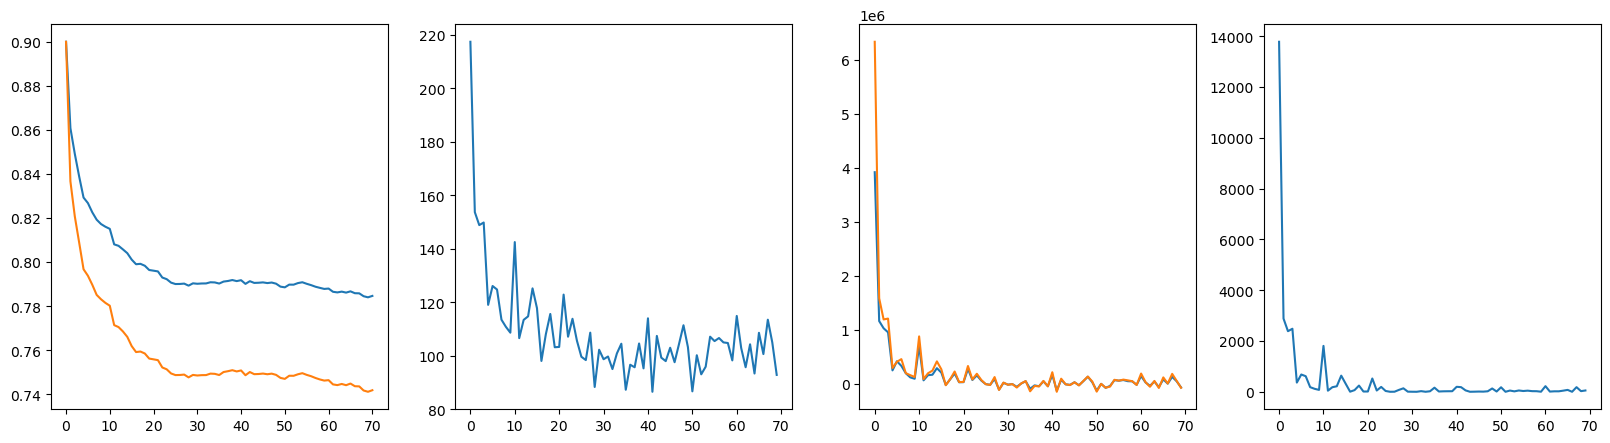

In [50]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].plot(p_rev_vals)
axs[0].plot(p_vchg_vals)
axs[1].plot(msds)
axs[2].plot(grads_rev)
axs[2].plot(grads_vchg)
axs[3].plot(losses)

In [85]:
p_reverse = t.tensor(0.5,device=device)
p_reverse.requires_grad_()
p_vchg = t.tensor(0.5,device=device)
p_vchg.requires_grad_()
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)
target_msd = 200

p_rev_vals = [p_reverse.detach().clone().cpu().numpy()]
p_vchg_vals = [p_vchg.detach().clone().cpu().numpy()]
grads_rev = []
grads_vchg = []
msds = []
losses = []

t.autograd.set_detect_anomaly(False)

In [86]:
for i in tqdm(range(50)):
    test_batch, dir_x, dir_y, v_x, v_y = init_batch(500,512,device=device)
    #print(dir_x.shape)
    for j in range(100):
        test_batch, dir_x, v_x = take_step(test_batch, v_x, p_vchg, dir_x, p_reverse, dim=-1)
        test_batch, dir_y, v_y = take_step(test_batch, v_y, p_vchg, dir_y, p_reverse, dim=-2)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - target_msd)**2
    grad_rev, grad_vchg = t.autograd.grad(loss,(p_reverse, p_vchg))
    p_reverse = t.clamp(p_reverse - 1e-7 * grad_rev, min=0, max=1)
    p_vchg = t.clamp(p_vchg - 1e-7 * grad_vchg, min=1e-5, max=1-1e-5)

    print(p_reverse,p_vchg)
    p_rev_vals.append(p_reverse.detach().clone().cpu().numpy())
    p_vchg_vals.append(p_vchg.detach().clone().cpu().numpy())
    grads_rev.append(grad_rev.detach().clone().cpu().numpy())
    grads_vchg.append(grad_vchg.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())


  2%|▏         | 1/50 [00:07<05:55,  7.25s/it]

tensor(0.4988, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5013, device='cuda:0', grad_fn=<ClampBackward1>)


  4%|▍         | 2/50 [00:14<05:44,  7.18s/it]

tensor(0.4965, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4991, device='cuda:0', grad_fn=<ClampBackward1>)


  6%|▌         | 3/50 [00:21<05:36,  7.16s/it]

tensor(0.4946, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5010, device='cuda:0', grad_fn=<ClampBackward1>)


  8%|▊         | 4/50 [00:28<05:28,  7.15s/it]

tensor(0.4926, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5032, device='cuda:0', grad_fn=<ClampBackward1>)


 10%|█         | 5/50 [00:35<05:21,  7.14s/it]

tensor(0.4904, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5021, device='cuda:0', grad_fn=<ClampBackward1>)


 12%|█▏        | 6/50 [00:42<05:14,  7.14s/it]

tensor(0.4881, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5025, device='cuda:0', grad_fn=<ClampBackward1>)


 14%|█▍        | 7/50 [00:50<05:06,  7.14s/it]

tensor(0.4834, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4991, device='cuda:0', grad_fn=<ClampBackward1>)


 16%|█▌        | 8/50 [00:57<04:59,  7.14s/it]

tensor(0.4812, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4995, device='cuda:0', grad_fn=<ClampBackward1>)


 18%|█▊        | 9/50 [01:04<04:52,  7.14s/it]

tensor(0.4748, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4992, device='cuda:0', grad_fn=<ClampBackward1>)


 20%|██        | 10/50 [01:11<04:45,  7.13s/it]

tensor(0.4690, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4976, device='cuda:0', grad_fn=<ClampBackward1>)


 22%|██▏       | 11/50 [01:18<04:38,  7.13s/it]

tensor(0.4590, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4977, device='cuda:0', grad_fn=<ClampBackward1>)


 24%|██▍       | 12/50 [01:25<04:31,  7.13s/it]

tensor(0.4474, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4926, device='cuda:0', grad_fn=<ClampBackward1>)


 26%|██▌       | 13/50 [01:32<04:23,  7.13s/it]

tensor(0.4330, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4915, device='cuda:0', grad_fn=<ClampBackward1>)


 28%|██▊       | 14/50 [01:39<04:16,  7.13s/it]

tensor(0.4137, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4901, device='cuda:0', grad_fn=<ClampBackward1>)


 30%|███       | 15/50 [01:47<04:09,  7.13s/it]

tensor(0.3933, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4833, device='cuda:0', grad_fn=<ClampBackward1>)


 32%|███▏      | 16/50 [01:54<04:02,  7.13s/it]

tensor(0.3648, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4740, device='cuda:0', grad_fn=<ClampBackward1>)


 34%|███▍      | 17/50 [02:01<03:57,  7.21s/it]

tensor(0.3337, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4643, device='cuda:0', grad_fn=<ClampBackward1>)


 36%|███▌      | 18/50 [02:08<03:49,  7.19s/it]

tensor(0.3050, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4547, device='cuda:0', grad_fn=<ClampBackward1>)


 38%|███▊      | 19/50 [02:15<03:42,  7.17s/it]

tensor(0.2718, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4428, device='cuda:0', grad_fn=<ClampBackward1>)


 40%|████      | 20/50 [02:23<03:34,  7.16s/it]

tensor(0.2561, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4378, device='cuda:0', grad_fn=<ClampBackward1>)


 42%|████▏     | 21/50 [02:30<03:27,  7.15s/it]

tensor(0.2461, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4343, device='cuda:0', grad_fn=<ClampBackward1>)


 44%|████▍     | 22/50 [02:37<03:20,  7.15s/it]

tensor(0.2313, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4285, device='cuda:0', grad_fn=<ClampBackward1>)


 46%|████▌     | 23/50 [02:44<03:12,  7.14s/it]

tensor(0.2486, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4347, device='cuda:0', grad_fn=<ClampBackward1>)


 48%|████▊     | 24/50 [02:51<03:05,  7.14s/it]

tensor(0.2376, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4304, device='cuda:0', grad_fn=<ClampBackward1>)


 50%|█████     | 25/50 [02:58<02:58,  7.13s/it]

tensor(0.2709, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4427, device='cuda:0', grad_fn=<ClampBackward1>)


 52%|█████▏    | 26/50 [03:05<02:51,  7.13s/it]

tensor(0.2431, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4332, device='cuda:0', grad_fn=<ClampBackward1>)


 54%|█████▍    | 27/50 [03:12<02:44,  7.13s/it]

tensor(0.2692, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4423, device='cuda:0', grad_fn=<ClampBackward1>)


 56%|█████▌    | 28/50 [03:20<02:36,  7.13s/it]

tensor(0.2596, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4390, device='cuda:0', grad_fn=<ClampBackward1>)


 58%|█████▊    | 29/50 [03:27<02:29,  7.13s/it]

tensor(0.2604, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4393, device='cuda:0', grad_fn=<ClampBackward1>)


 60%|██████    | 30/50 [03:34<02:22,  7.13s/it]

tensor(0.2496, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4358, device='cuda:0', grad_fn=<ClampBackward1>)


 62%|██████▏   | 31/50 [03:41<02:15,  7.13s/it]

tensor(0.2680, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4433, device='cuda:0', grad_fn=<ClampBackward1>)


 64%|██████▍   | 32/50 [03:48<02:08,  7.13s/it]

tensor(0.2542, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4384, device='cuda:0', grad_fn=<ClampBackward1>)


 66%|██████▌   | 33/50 [03:55<02:01,  7.13s/it]

tensor(0.2540, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4384, device='cuda:0', grad_fn=<ClampBackward1>)


 68%|██████▊   | 34/50 [04:02<01:54,  7.13s/it]

tensor(0.2463, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4358, device='cuda:0', grad_fn=<ClampBackward1>)


 70%|███████   | 35/50 [04:09<01:46,  7.13s/it]

tensor(0.2659, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4439, device='cuda:0', grad_fn=<ClampBackward1>)


 72%|███████▏  | 36/50 [04:17<01:39,  7.13s/it]

tensor(0.2515, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4393, device='cuda:0', grad_fn=<ClampBackward1>)


 74%|███████▍  | 37/50 [04:24<01:32,  7.13s/it]

tensor(0.2664, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4442, device='cuda:0', grad_fn=<ClampBackward1>)


 76%|███████▌  | 38/50 [04:31<01:25,  7.13s/it]

tensor(0.2413, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4360, device='cuda:0', grad_fn=<ClampBackward1>)


 78%|███████▊  | 39/50 [04:38<01:18,  7.13s/it]

tensor(0.2760, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4488, device='cuda:0', grad_fn=<ClampBackward1>)


 80%|████████  | 40/50 [04:45<01:11,  7.13s/it]

tensor(0.2513, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4425, device='cuda:0', grad_fn=<ClampBackward1>)


 82%|████████▏ | 41/50 [04:52<01:04,  7.13s/it]

tensor(0.2485, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4416, device='cuda:0', grad_fn=<ClampBackward1>)


 84%|████████▍ | 42/50 [04:59<00:57,  7.13s/it]

tensor(0.2719, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4495, device='cuda:0', grad_fn=<ClampBackward1>)


 86%|████████▌ | 43/50 [05:07<00:49,  7.13s/it]

tensor(0.2604, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4460, device='cuda:0', grad_fn=<ClampBackward1>)


 88%|████████▊ | 44/50 [05:14<00:42,  7.13s/it]

tensor(0.2485, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4423, device='cuda:0', grad_fn=<ClampBackward1>)


 90%|█████████ | 45/50 [05:21<00:35,  7.13s/it]

tensor(0.2475, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4420, device='cuda:0', grad_fn=<ClampBackward1>)


 92%|█████████▏| 46/50 [05:28<00:28,  7.13s/it]

tensor(0.2439, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4409, device='cuda:0', grad_fn=<ClampBackward1>)


 94%|█████████▍| 47/50 [05:35<00:21,  7.13s/it]

tensor(0.2351, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4382, device='cuda:0', grad_fn=<ClampBackward1>)


 96%|█████████▌| 48/50 [05:42<00:14,  7.13s/it]

tensor(0.2418, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4400, device='cuda:0', grad_fn=<ClampBackward1>)


 98%|█████████▊| 49/50 [05:49<00:07,  7.13s/it]

tensor(0.2585, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4455, device='cuda:0', grad_fn=<ClampBackward1>)


100%|██████████| 50/50 [05:56<00:00,  7.14s/it]

tensor(0.2615, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4466, device='cuda:0', grad_fn=<ClampBackward1>)


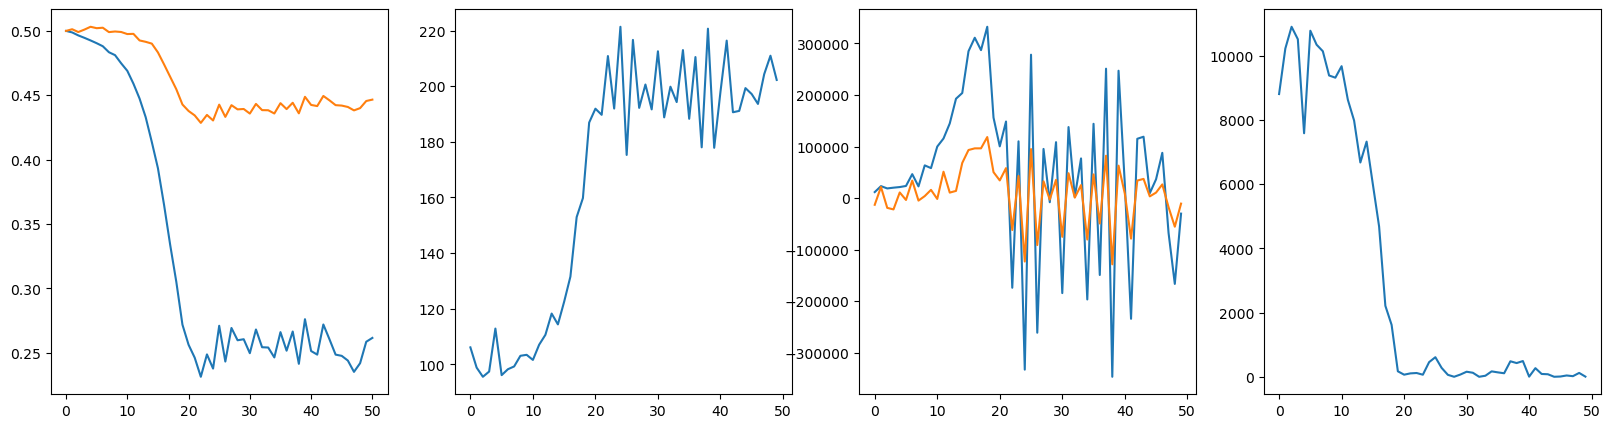

In [87]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].plot(p_rev_vals)
axs[0].plot(p_vchg_vals)
axs[1].plot(msds)
axs[2].plot(grads_rev)
axs[2].plot(grads_vchg)
axs[3].plot(losses)

In [73]:
p_reverse = t.tensor(0.5,device=device)
p_reverse.requires_grad_()
p_vchg = t.tensor(0.5,device=device)
p_vchg.requires_grad_()
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid,device=device)
target_msd = 50

p_rev_vals = [p_reverse.detach().clone().cpu().numpy()]
p_vchg_vals = [p_vchg.detach().clone().cpu().numpy()]
grads_rev = []
grads_vchg = []
msds = []
losses = []

t.autograd.set_detect_anomaly(False)

In [74]:
for i in tqdm(range(50)):
    test_batch, dir_x, dir_y, v_x, v_y = init_batch(400,512,device=device)
    #print(dir_x.shape)
    for j in range(100):
        test_batch, dir_x, v_x = take_step(test_batch, v_x, p_vchg, dir_x, p_reverse, dim=-1)
        test_batch, dir_y, v_y = take_step(test_batch, v_y, p_vchg, dir_y, p_reverse, dim=-2)
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    loss = (msd - target_msd)**2
    grad_rev, grad_vchg = t.autograd.grad(loss,(p_reverse, p_vchg))
    p_reverse = t.clamp(p_reverse - 1e-6 * grad_rev, min=0, max=1)
    p_vchg = t.clamp(p_vchg - 1e-6 * grad_vchg, min=0, max=1)

    print(p_reverse,p_vchg)
    p_rev_vals.append(p_reverse.detach().clone().cpu().numpy())
    p_vchg_vals.append(p_vchg.detach().clone().cpu().numpy())
    grads_rev.append(grad_rev.detach().clone().cpu().numpy())
    grads_vchg.append(grad_vchg.detach().clone().cpu().numpy())
    msds.append(msd.detach().clone().cpu().numpy())
    losses.append(loss.detach().clone().cpu().numpy())


  2%|▏         | 1/50 [00:06<04:54,  6.02s/it]

tensor(0.5004, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<ClampBackward1>)


  4%|▍         | 2/50 [00:11<04:41,  5.87s/it]

tensor(0.5001, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4985, device='cuda:0', grad_fn=<ClampBackward1>)


  6%|▌         | 3/50 [00:17<04:33,  5.82s/it]

tensor(0.5004, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4994, device='cuda:0', grad_fn=<ClampBackward1>)


  8%|▊         | 4/50 [00:23<04:26,  5.80s/it]

tensor(0.5006, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4985, device='cuda:0', grad_fn=<ClampBackward1>)


 10%|█         | 5/50 [00:29<04:20,  5.79s/it]

tensor(0.5009, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4983, device='cuda:0', grad_fn=<ClampBackward1>)


 12%|█▏        | 6/50 [00:34<04:14,  5.78s/it]

tensor(0.5026, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5007, device='cuda:0', grad_fn=<ClampBackward1>)


 14%|█▍        | 7/50 [00:40<04:08,  5.78s/it]

tensor(0.5019, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5011, device='cuda:0', grad_fn=<ClampBackward1>)


 16%|█▌        | 8/50 [00:46<04:02,  5.77s/it]

tensor(0.5032, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5008, device='cuda:0', grad_fn=<ClampBackward1>)


 18%|█▊        | 9/50 [00:52<03:56,  5.77s/it]

tensor(0.5037, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5014, device='cuda:0', grad_fn=<ClampBackward1>)


 20%|██        | 10/50 [00:57<03:50,  5.77s/it]

tensor(0.5044, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4993, device='cuda:0', grad_fn=<ClampBackward1>)


 22%|██▏       | 11/50 [01:03<03:44,  5.76s/it]

tensor(0.5048, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4995, device='cuda:0', grad_fn=<ClampBackward1>)


 24%|██▍       | 12/50 [01:09<03:39,  5.76s/it]

tensor(0.5057, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5000, device='cuda:0', grad_fn=<ClampBackward1>)


 26%|██▌       | 13/50 [01:15<03:33,  5.77s/it]

tensor(0.5059, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4976, device='cuda:0', grad_fn=<ClampBackward1>)


 28%|██▊       | 14/50 [01:20<03:27,  5.77s/it]

tensor(0.5065, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4966, device='cuda:0', grad_fn=<ClampBackward1>)


 30%|███       | 15/50 [01:26<03:21,  5.77s/it]

tensor(0.5056, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.4998, device='cuda:0', grad_fn=<ClampBackward1>)


 32%|███▏      | 16/50 [01:32<03:16,  5.77s/it]

tensor(0.5051, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5009, device='cuda:0', grad_fn=<ClampBackward1>)


 34%|███▍      | 17/50 [01:38<03:10,  5.77s/it]

tensor(0.5042, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5008, device='cuda:0', grad_fn=<ClampBackward1>)


 36%|███▌      | 18/50 [01:44<03:04,  5.76s/it]

tensor(0.5041, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5003, device='cuda:0', grad_fn=<ClampBackward1>)


 38%|███▊      | 19/50 [01:49<02:59,  5.78s/it]

tensor(0.5039, device='cuda:0', grad_fn=<ClampBackward1>) tensor(0.5015, device='cuda:0', grad_fn=<ClampBackward1>)


KeyboardInterrupt: 

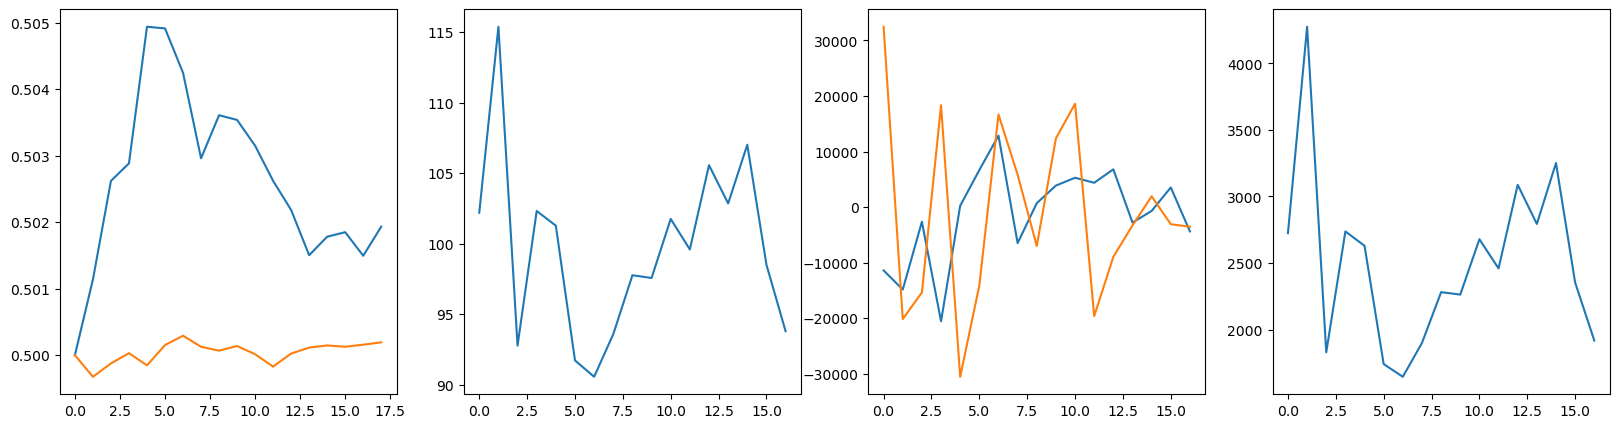

In [72]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].plot(p_rev_vals)
axs[0].plot(p_vchg_vals)
axs[1].plot(msds)
axs[2].plot(grads_rev)
axs[2].plot(grads_vchg)
axs[3].plot(losses)